In [1]:
import numpy as np
from astropy.io import ascii
import pandas as pd
import matplotlib.pyplot as plt
import pystan as ps
import arviz as av
import seaborn as sns
import pickle
import astropy.units as u
import astropy.constants as const

%matplotlib inline

In [2]:
data = ascii.read('/Users/samberek/Courses/1501project/pythoncode/NGC1407_GC.cat')

In [3]:
data.remove_row(348)
data.remove_row(343)
data.remove_row(264)
data.remove_row(13) 

In [4]:
los_vel = data['RV'] - 1779

In [5]:
def dist_calc(angrad):
    angle = angrad*u.arcmin
    radangle = angle.to(u.rad)
    convert = np.tan(radangle/2)*2*(26.8*u.Mpc)
    
    return (convert.to(u.kpc)).value

radius_kpc = np.array([dist_calc(i) for i in data['RAD']])

Data needs to be in a dictionary to be passed to Stan

In [6]:
#I think these need to be numpy arrays, they should already be but potential problem point
standata = {
    'N': len(data),

    'r_obs': radius_kpc,
    'rv_obs': los_vel,
    'rv_err': data['RV_err'],
}

In [37]:
with open('single_hernquist.stan', 'r') as f:
    stancode = f.read()
    
sm = ps.StanModel(model_code=stancode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37a24d5af8dc5769d69a1b1a726c954c NOW.


Initial values for priors

In [48]:
def initial_values():
    return {
        
        #there needs to be a better prior here
        #'rho0': 1e6,
        'logM': 12.8,
        'a': 2,
        
        'x': np.full(standata['N'], 10),
        'yv': np.full(standata['N'], 10),
        'zv': np.full(standata['N'], 10),
        
#         'x': np.full(standata['N'], 1e-6),
#         'yv': np.full(standata['N'], 1e-6),
#         'zv': np.full(standata['N'], 1e-6),
        #'xv': np.random.uniform(min(standata['rv_obs']), max(standata['rv_obs']), size=int(standata['N']))
    }

In [34]:
adapt = {
    'adapt_delta': 0.90,
    'max_treedepth': 12
}

In [49]:
fit = sm.sampling(data=standata,
                  init=initial_values,
                  n_jobs = 1,
                  #thin = 50, #trying this to un-stick it
                  iter=2000, #best value here? a few thousand?
                  #chains=1, #1 for diagnostics
                  #control = adapt, 
                  #warmup=500, 
                  #seed=101,
                  verbose=True
                 )


#it initializes when I divide the radii by 4 but not by 3...max values of 28 vs 37
#nan values at 13 and 2 more

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [172]:
# def df_hernquist(x, r, xv, yv, zv, rho0, a):
    
#     pos = np.sqrt(r**2+x**2)
#     vel = np.sqrt(xv**2+yv**2+zv**2)
    
#     M = 2.*np.pi*rho0*a**3
#     pot = -4.3009173e-6*M/(pos+a) 
#     epsilon = -vel**2/2 - pot
#     epsilon_tilde = epsilon*a / (4.3009173e-6*M)

#     mult_one = (4.3009173e-6*M*a)**(-1.5) / (np.sqrt(2)*(2.*np.pi)**3)
#     mult_two = np.sqrt(epsilon_tilde) / ((1-epsilon_tilde)**2) 
#     bracket_one = (1-2*epsilon_tilde)* (8*epsilon_tilde**2 - 8*epsilon_tilde - 3)
#     bracket_two = 3*np.arcsin(np.sqrt(epsilon_tilde)) / np.sqrt(epsilon_tilde*(1-epsilon_tilde))

#     f_eps = mult_one * mult_two * (bracket_one+bracket_two)

#     return f_eps

In [173]:
# for i in range(len(data)):
#     x = 0
#     yv = 0
#     zv = 0
#     rho0 = 1e6
#     a = 100
#     df = df_hernquist(x, radius_kpc[i], los_vel[i], yv, zv, rho0, a)
#     print(i, df)
    

In [174]:
# print(data[13], data[264], data[343], data[348])

# print(los_vel[13], los_vel[264], los_vel[343], los_vel[348])
# print(radius_kpc[13], radius_kpc[264], radius_kpc[343], radius_kpc[348])

In [175]:
# def eps_tilde(x, r, xv, yv, zv, rho0, a):
    
#     pos = np.sqrt(r**2+x**2)
#     vel = np.sqrt(xv**2+yv**2+zv**2)
    
#     M = 2.*np.pi*rho0*a**3
#     pot = -4.3009173e-6*M/(pos+a) 
#     epsilon = -vel**2/2 - pot
#     epsilon_tilde = epsilon*a / (4.3009173e-6*M)

# #     mult_one = (4.3009173e-6*M*a)**(-1.5) / (np.sqrt(2)*(2.*np.pi)**3)
# #     mult_two = np.sqrt(epsilon_tilde) / ((1-epsilon_tilde)**2) 
# #     bracket_one = (1-2*epsilon_tilde)* (8*epsilon_tilde**2 - 8*epsilon_tilde - 3)
# #     bracket_two = 3*np.arcsin(np.sqrt(epsilon_tilde)) / np.sqrt(epsilon_tilde*(1-epsilon_tilde))

# #     f_eps = mult_one * mult_two * (bracket_one+bracket_two)

#     return M, pot, epsilon, epsilon_tilde


# test = eps_tilde(0, radius_kpc[13], los_vel[13], 0, 0, 1e6, 100)
# print(test)

# #these four gc's seem to be unbound with the initial conditions I've used...

In [50]:
print(fit.stansummary())

Inference for Stan model: anon_model_37a24d5af8dc5769d69a1b1a726c954c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logM      14.1    0.04   0.57  12.94  13.66  14.19  14.59  14.95    232   1.01
loga      2.11    0.05   0.74   1.04   1.48   2.03   2.64   3.65    240   1.01
x[1]     29.84    1.06  21.26   1.54  12.81  25.59  43.24  77.97    404   1.01
x[2]     31.45     1.0  22.33   1.09  13.26  27.46  45.93  83.77    495    1.0
x[3]     30.42    0.91  20.51   1.52  14.32  26.75  43.44  76.22    506    1.0
x[4]     30.72    0.97  21.08   1.51  13.29  27.88   44.8  77.03    473    1.0
x[5]     32.06    1.11   23.5   1.42  13.04  27.29  47.14  87.47    450    1.0
x[6]      29.3    0.88  21.26   1.37  11.64  25.75   42.2  78.43    587   1.01
x[7]     31.27     1.0  22.88   1.39  12.85  26.43  45.41  85.75    527    1.0
x[8]     32.52    0.9

In [40]:
params = ["logM", "loga"]

In [41]:
print(fit.stansummary(pars=params))

Inference for Stan model: anon_model_37a24d5af8dc5769d69a1b1a726c954c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logM  14.07    0.05    0.6  12.93   13.6  14.16  14.58  14.95    168   1.04
loga   2.03    0.05   0.72   1.03    1.4   1.92   2.55   3.55    198   1.01

Samples were drawn using NUTS at Fri Feb 12 14:00:04 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


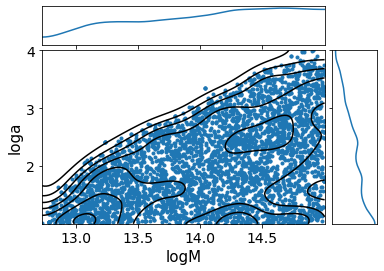

In [42]:
av.plot_pair(fit, var_names=params, kind=['kde', 'scatter'], marginals=True);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd985cb9b50>,
      dtype=object)

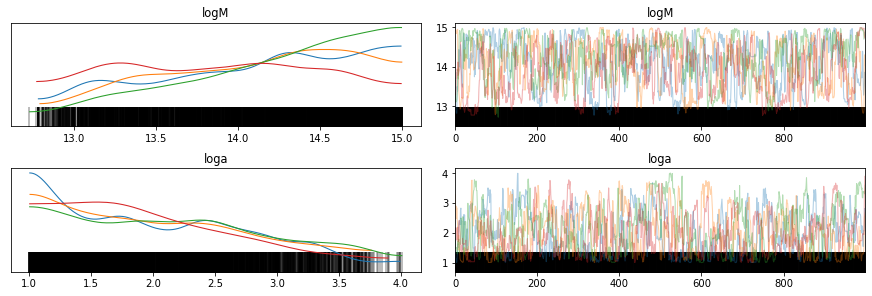

In [43]:
av.plot_trace(fit, var_names=params)
#plt.savefig('/Users/samberek/Courses/1501project/results/mass_dists/singlehernquist_traceplots3.pdf')

In [53]:
la = fit.extract()

In [54]:
def mass_enclosed(r, samples, full=False):
    mass = 10**samples['logM']
    a = 10**samples['loga']
    masses = mass*(r/a**2/(1+(r/a)**2))


#     if full: 
#         return masses
    
    return np.quantile(masses, [0.025, 0.125, 0.25, 0.5, 0.75, 0.875, 0.975]) # quantiles that we want to get

In [60]:
print("Enclosed mass: %.4g" %mass_enclosed(300,la)[3])

Enclosed mass: 1.675e+11


(array([1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13,
        1.e+14, 1.e+15]),
 <a list of 10 Text major ticklabel objects>)

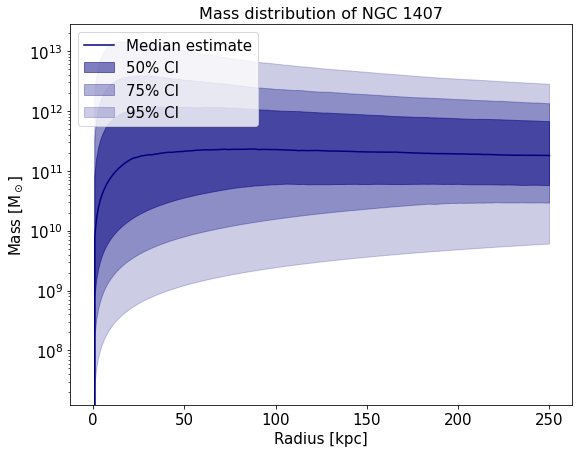

In [55]:
plt.figure(figsize=(9, 7))
radii = np.arange(251) # up to 250 kpc
masses = np.zeros((len(radii), 7))

for r in radii:
    masses[r] = mass_enclosed(r, la) # 251 x 7 array of various quantiles of masses at different radii
    
plt.plot(radii, masses[:, 3], c='navy', label='Median estimate')
plt.fill_between(radii, masses[:, 2], masses[:, 4], alpha=0.5, color='navy', label='50% CI')
plt.fill_between(radii, masses[:, 1], masses[:, 5], alpha=0.3, color='navy', label='75% CI')
plt.fill_between(radii, masses[:, 0], masses[:, 6], alpha=0.2, color='navy', label='95% CI')

plt.legend(loc='upper left', fontsize=15)
plt.title('Mass distribution of NGC 1407', fontsize=16)
plt.xlabel('Radius [kpc]', fontsize=15)
plt.ylabel(r'Mass [M$_\odot$]', fontsize=15)
#plt.xlim(-1, 100)
plt.yscale('log')
plt.xticks(size=15)
plt.yticks(size=15)
#plt.savefig('/Users/samberek/Courses/1501project/results/mass_dists/singlehernquist_log3.pdf')

In [ ]:
#I'll do M_200 by calculating the radius for which density is 200 times density of the universe

def calc_rvir(gamma, phi0, H=0.678e-3):
    return (gamma * phi0 / (100 * H**2)) ** (1 / 2 + gamma)

rvir = calc_rvir(
    np.median(la['p_gamma']), 
    np.median(la['p_phi0'])
) / 1000 # convert to kpc

plt.figure(figsize=(9, 7))

virial_mass = mass_at_radius(rvir, la, full=True)

sns.distplot(virial_mass) # density 
plt.axvline(np.median(virial_mass)) # draw a vertical line at the median mass
plt.annotate(rf"median: {np.median(virial_mass):.2f} $\times 10^{{12}}$ M$_\odot$", xy=(0.55, 0.7), xycoords='axes fraction', fontsize=15)

plt.title(rf'Distribution of M$_{{{200}}}$ = M(<{rvir:.0f} kpc)', fontsize=15)
plt.xlabel(r'Mass [$\times 10^{12}$ M$_\odot$]', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xticks(size=15)
plt.yticks(size=15);